In [ ]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
url = "https://www.dropbox.com/scl/fi/wxc1jz8spd0thbzi4oj3h/mlp_data2.csv?rlkey=p0a22wgqlxdnxm7pum27lh86y&st=jelhn8kg&dl=1"

filename = "MLP.csv"

response = requests.get(url)

# Save the file locally
with open(filename, 'wb') as file:
    file.write(response.content)

In [ ]:
csv_file_path = filename  # Replace with the actual path to the produced CSV file
# Load the CSV into a DataFrame and assign it to the desired column names
df = pd.read_csv(csv_file_path)

print(df.columns)

Index(['Filename', 'Depth', 'Activations-Params', 'Activation Function',
       'Total Activations', 'Total Parameters', 'Batch Size',
       'Batch Normalization Layers', 'Dropout Layers', 'Max GPU Memory (MiB)',
       'Avg GPUTL', 'Avg GRACT', 'Avg SMACT', 'Avg SMOCC', 'Avg FP32A'],
      dtype='object')


In [ ]:
df = df[['Max GPU Memory (MiB)',                                                                # output (target)
         'Depth', 'Activation Function', 'Batch Size', 'Batch Normalization Layers',            # input features
         'Dropout Layers', 'Total Parameters', 'Total Activations', 'Activations-Params', ]]

# Map the existing columns to your desired column structure
df = df.rename(columns={
    'Max GPU Memory (MiB)': 'real_memory_usage',        # target (output) variable
    # input variables
    'Depth': 'layers',                                  # number of linear layers
    'Batch Normalization Layers': 'batch_norm_layer',   # number of batch normalization layers
    'Dropout Layers': 'dropout_layers',                  # number dropout layers
    'Activation Function': 'activation_function',       # activation function, e.g., RELU, Tanh, ...
    'Batch Size': 'batch_size',                         # batch size
    'Total Parameters': 'all_parameters',               # all parameters in the network (weights + biases)
    'Total Activations': 'all_activations',             # all activation in the network (in MLP case: #neurons)
    'Activations-Params': 'params_neurons_list'        # the list showing the order of (layer type, activations, parameters)
})

df.head()

,real_memory_usage,layers,activation_function,batch_size,batch_norm_layer,dropout_layers,all_parameters,all_activations,params_neurons_list
0,1545,3,ReLU,996,2,2,3560152,7430,"[('linear', 1173, 2753031), ('batch_normalizat..."
1,1569,9,Softplus,939,0,8,3639009,13272,"[('linear', 936, 1754064), ('Softplus', 936, 0..."
2,1507,10,GELU,873,0,0,1207445,4596,"[('linear', 615, 757065), ('GELU', 615, 0), ('..."
3,1457,4,Mish,518,3,0,233316,1635,"[('linear', 295, 174640), ('batch_normalizatio..."
4,4505,11,SELU,983,0,0,140336299,74986,"[('linear', 3742, 14006306), ('SELU', 3742, 0)..."


In [ ]:
# List of activation functions
activations = ['ELU', 'GELU', 'Identity', 'LeakyReLU', 'Mish', 'PReLU', 'ReLU', 'SELU', 'SiLU', 'Softplus', 'Tanh']

# Function to create positional encoding
def positional_encoding_2d(num_states):
    positions = []
    for i in range(num_states):
        position = (np.sin(i * np.pi / num_states), np.cos(i * np.pi / num_states))
        positions.append(position)
    return np.array(positions)

# Generate positional encodings
positional_encodings = positional_encoding_2d(len(activations))
activation_to_encoding = {activation: positional_encodings[i] for i, activation in enumerate(activations)}

# Apply positional encoding to 'activation_function' column
df['activation_encoding_sin'] = df['activation_function'].map(lambda x: activation_to_encoding[x][0])
df['activation_encoding_cos'] = df['activation_function'].map(lambda x: activation_to_encoding[x][1])

In [ ]:
bins = [i*1000 for i in range(0, 6)]  # Define your bin edges

bins.append(float('inf'))
labels = [i for i in range(len(bins)-1)]  # Labels corresponding to the bins


print("Bins: ", bins, "Number of bins: ", len(bins))
print("Labels: ", labels, "Number of labels: ", len(labels))


# Use pd.cut() to create a new column with labels based on the bins
df['memory_usage_label'] = pd.cut(df['real_memory_usage'], bins=bins, labels=labels, right=True)

# print(df, df['memory_usage_label'], "| length of labels", len(labels))


df.head()

Bins:  [0, 1000, 2000, 3000, 4000, 5000, inf] Number of bins:  7
Labels:  [0, 1, 2, 3, 4, 5] Number of labels:  6


,real_memory_usage,layers,activation_function,batch_size,batch_norm_layer,dropout_layers,all_parameters,all_activations,params_neurons_list,activation_encoding_sin,activation_encoding_cos,memory_usage_label
0,1545,3,ReLU,996,2,2,3560152,7430,"[('linear', 1173, 2753031), ('batch_normalizat...",0.989821,-0.142315,1
1,1569,9,Softplus,939,0,8,3639009,13272,"[('linear', 936, 1754064), ('Softplus', 936, 0...",0.540641,-0.841254,1
2,1507,10,GELU,873,0,0,1207445,4596,"[('linear', 615, 757065), ('GELU', 615, 0), ('...",0.281733,0.959493,1
3,1457,4,Mish,518,3,0,233316,1635,"[('linear', 295, 174640), ('batch_normalizatio...",0.909632,0.415415,1
4,4505,11,SELU,983,0,0,140336299,74986,"[('linear', 3742, 14006306), ('SELU', 3742, 0)...",0.909632,-0.415415,4


In [ ]:
from sklearn.manifold import TSNE

X = df[['layers', 'batch_size', 'all_parameters', 'all_activations', 'batch_norm_layer', 'dropout_layers', 'activation_encoding_sin', 'activation_encoding_cos']]  # Input features
y = df['memory_usage_label']  # Actual GPU memory usageplt.show()

# Initialize the t-SNE model
tsne = TSNE(n_components=2, random_state=43)

# Fit and transform the features
tsne_results = tsne.fit_transform(df[['layers', 'batch_size', 'all_parameters', 'all_activations', 'batch_norm_layer', 'dropout_layers', 'activation_encoding_sin', 'activation_encoding_cos']])

# Get sorted unique labels
unique_labels = sorted(np.unique(y))

# Assign colors consistently
colors = plt.cm.get_cmap("tab10", len(unique_labels)).colors  # Get fixed colors
label_color_map = {label: colors[i] for i, label in enumerate(unique_labels)}  # Dict mapping labels to colors

<ipython-input-54-9ed9fd185ed0>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels)).colors  # Get fixed colors


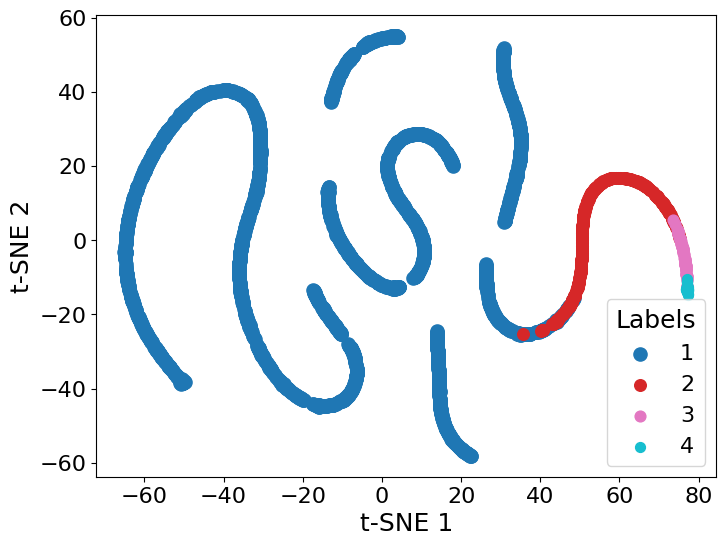

In [ ]:
tsne_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
tsne_df['label'] = df['memory_usage_label']

# Remove NaNs
# tsne_df = tsne_df.dropna(subset=['label'])

fixed_sizes = [90, 70, 60, 50, 40, 20]

# Assign each label a size in a cyclic manner
cluster_sizes = {label: fixed_sizes[i % len(fixed_sizes)] for i, label in enumerate(unique_labels)}

# Plot the results
plt.figure(figsize=(8, 6))
for label in unique_labels:
    subset = tsne_df[tsne_df['label'] == label]
    plt.scatter(subset['tsne1'], subset['tsne2'], color=label_color_map[label], label=label, s=cluster_sizes[label])

# Labels and legend
plt.xlabel('t-SNE 1', fontsize=18)
plt.ylabel('t-SNE 2', fontsize=18)

plt.xticks(fontsize=16)  # Change X-axis number font size
plt.yticks(fontsize=16)  # Change Y-axis number font size

plt.legend(fontsize=16, title="Labels", title_fontsize=18, loc="best")  # Sorted legend

# plt.savefig("MLP_tsne.pdf")

<ipython-input-60-194640aa79a4>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels)).colors


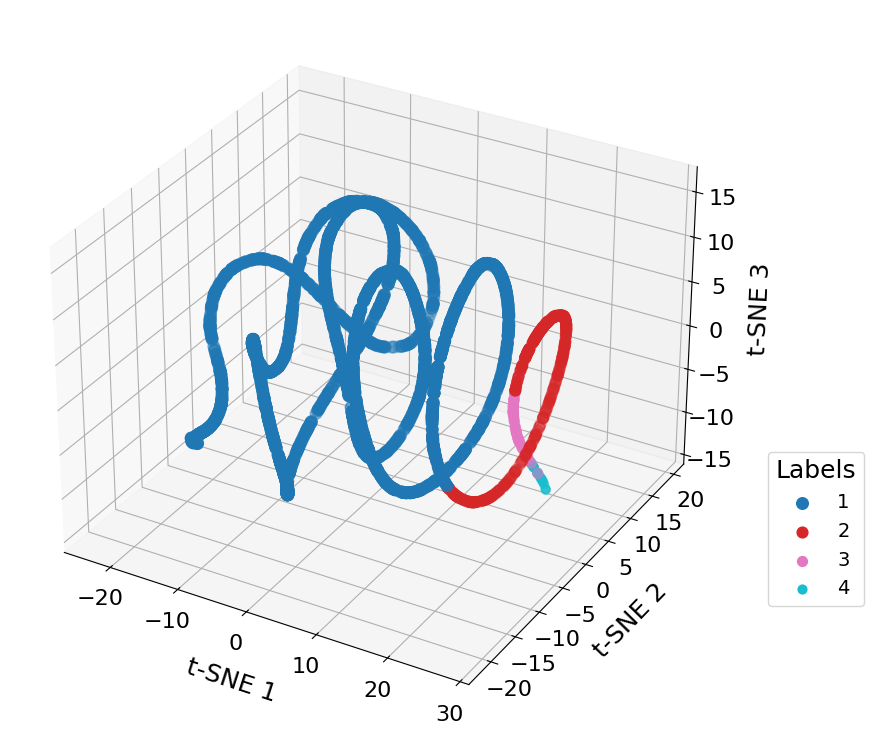

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Initialize the t-SNE model with 3 components
tsne = TSNE(n_components=3, random_state=43)

# Fit and transform the features
tsne_results = tsne.fit_transform(df[['layers', 'batch_size', 'all_parameters', 'all_activations', 'batch_norm_layer', 'dropout_layers', 'activation_encoding_sin', 'activation_encoding_cos']])


# --- Prepare DataFrame ---
tsne_df = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2', 'tsne3'])
tsne_df['label'] = y

# --- Visual Styling ---
unique_labels = sorted(tsne_df['label'].unique())
colors = plt.cm.get_cmap("tab10", len(unique_labels)).colors
label_color_map = {label: colors[i] for i, label in enumerate(unique_labels)}
fixed_sizes = [70, 60, 50, 40, 20]
cluster_sizes = {label: fixed_sizes[i % len(fixed_sizes)] for i, label in enumerate(unique_labels)}

# --- Plot ---
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

for label in unique_labels:
    subset = tsne_df[tsne_df['label'] == label]
    ax.scatter(subset['tsne1'], subset['tsne2'], subset['tsne3'],
               color=label_color_map[label],
               label=str(label),
               s=cluster_sizes[label])

# Axis labels
ax.set_xlabel('t-SNE 1', fontsize=18, labelpad=12)
ax.set_ylabel('t-SNE 2', fontsize=18, labelpad=12)
ax.set_zlabel('t-SNE 3', fontsize=18, labelpad=10)

# Tick font sizes
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='z', labelsize=16)

# Legend styling
ax.legend(title="Labels", fontsize=14, title_fontsize=18, loc='upper right', bbox_to_anchor=(1.2, 0.4))

# Layout adjustment
plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1)

# Export or display
# plt.savefig("MLP_tsne_3d.pdf")
plt.show()

<ipython-input-61-83da93417bb9>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels)).colors


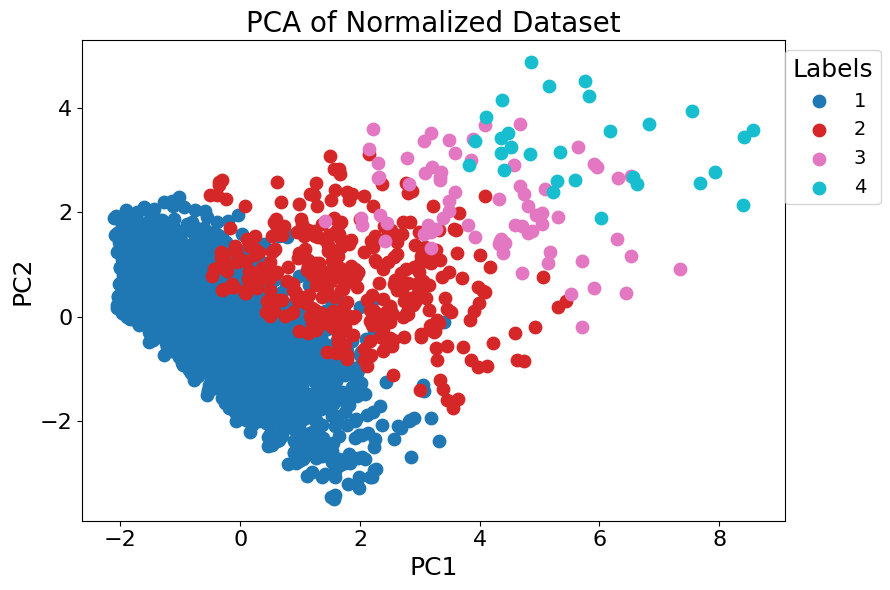

In [ ]:


# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)
pca1, pca2 = X_pca[:, 0], X_pca[:, 1]

# Unique labels and consistent color mapping
unique_labels = sorted(np.unique(y))
colors = plt.cm.get_cmap("tab10", len(unique_labels)).colors
label_color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

# Create figure
plt.figure(figsize=(9, 6))

# Plot each label with fixed color
for label in unique_labels:
    mask = y == label
    plt.scatter(pca1[mask], pca2[mask], color=label_color_map[label], label=str(label), s=80)

# Set labels and title
plt.xlabel('PC1', fontsize=18)
plt.ylabel('PC2', fontsize=18)
plt.title('PCA of Normalized Dataset', fontsize=20)

# Axis ticks styling
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Legend styling
plt.legend(title="Labels", fontsize=14, title_fontsize=18, loc='upper right', bbox_to_anchor=(1.15, 1))

# Adjust layout and save
plt.tight_layout()
# plt.savefig("MLP_first_phase_pca_2d.pdf")
plt.show()

<ipython-input-59-fbbaed890bca>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels)).colors  # Get fixed colors


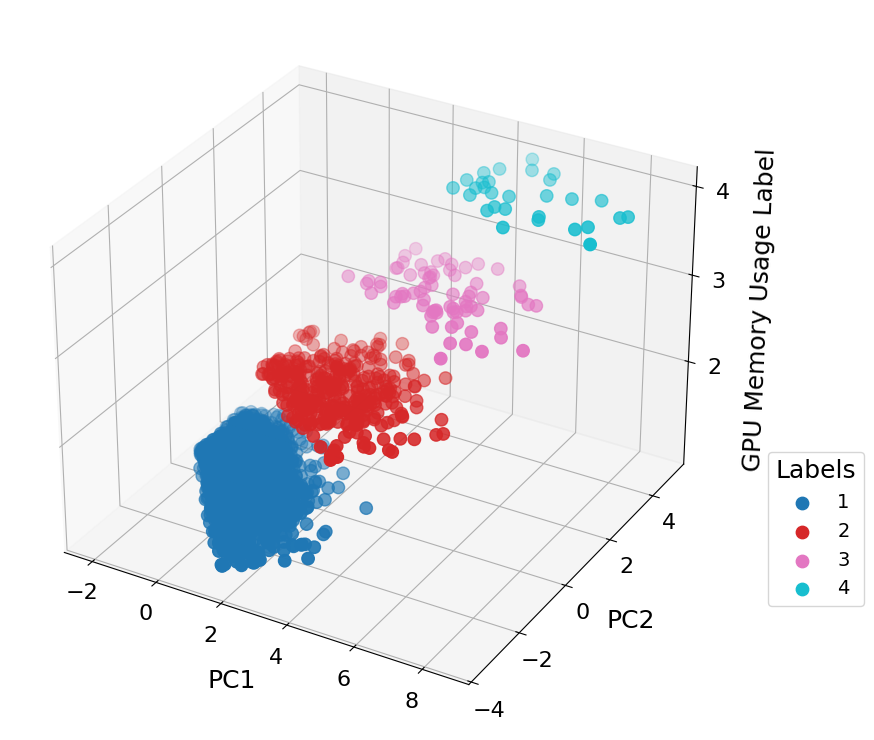

In [ ]:
import matplotlib.ticker as ticker

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Extract PCA components
pca1, pca2 = X_pca[:, 0], X_pca[:, 1]

# Ensure Z-axis starts with an even number and has exactly 4 steps
y_min, y_max = int(np.min(y)), int(np.max(y))
y_min = y_min + (y_min % 2)  # Ensure even start

# Generate exactly 4 even integer steps for Z-axis
int_ticks = np.linspace(start=y_min, stop=y_max, num=4, dtype=int)
int_ticks = np.unique(int_ticks)  # Avoid duplicate ticks

# Create figure
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Assign colors consistently
unique_labels = sorted(np.unique(y))
colors = plt.cm.get_cmap("tab10", len(unique_labels)).colors  # Get fixed colors
label_color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

# Plot each cluster with a fixed color (ONLY on Z-axis)
for label in unique_labels:
    mask = y == label
    ax.scatter(pca1[mask], pca2[mask], y[mask], color=label_color_map[label], label=str(label), s=80)

# Set labels and title
ax.set_xlabel(f'PC1', fontsize=18, labelpad=12)
ax.set_ylabel(f'PC2', fontsize=18, labelpad=12)
ax.set_zlabel('GPU Memory Usage Label', fontsize=18, labelpad=10)

# Increase tick label size (X, Y, and Z axis numbers)
ax.tick_params(axis='x', labelsize=16)  # Change X-axis number font size
ax.tick_params(axis='y', labelsize=16)  # Change Y-axis number font size
ax.tick_params(axis='z', labelsize=16)  # Change Z-axis number font size

# Set only 4 even numbers on the Z-axis
ax.set_zticks(int_ticks)
ax.zaxis.set_major_locator(ticker.FixedLocator(int_ticks))  # Ensure only these ticks appear

# Adjust legend position
ax.legend(title="Labels", fontsize=14, loc='upper right', title_fontsize=18, bbox_to_anchor=(1.2, 0.4))

plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1)  # Adjust layout

# plt.savefig("MLP_first_phase_pca_3d.pdf")

<ipython-input-49-a36b5e6521b2>:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels)).colors  # Get fixed colors


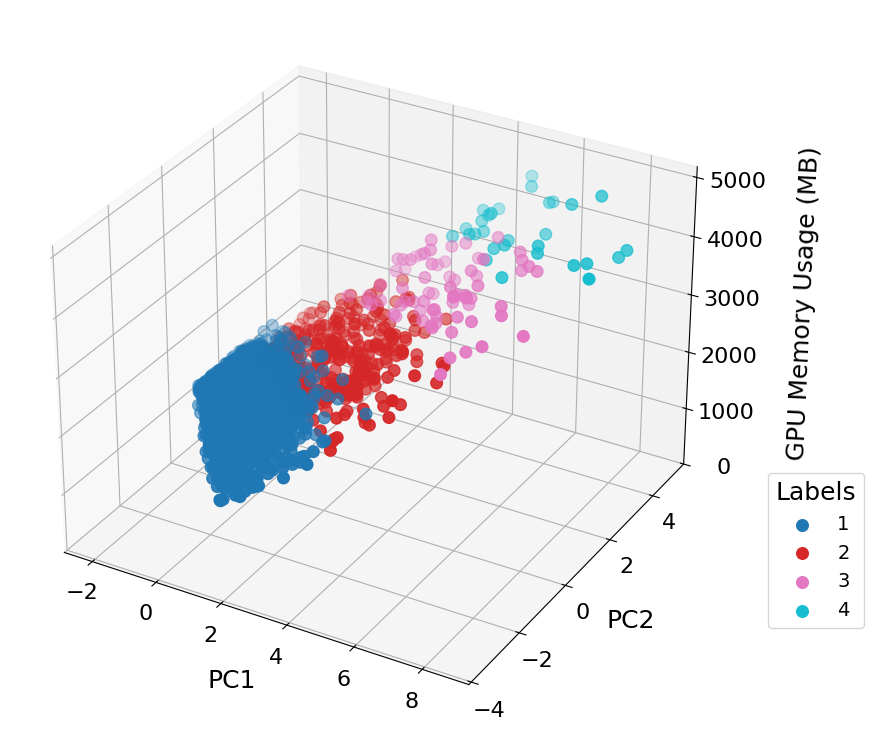

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.decomposition import PCA


y_real = df.loc[X.index, 'real_memory_usage']  # Ensure y_real matches X

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Extract PCA components
pca1, pca2 = X_pca[:, 0], X_pca[:, 1]

# Define Z-axis ticks (ONLY these values will appear)
int_ticks = [0, 1000, 2000, 3000, 4000, 5000]

# Create figure
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Assign colors based on original labels
unique_labels = sorted(np.unique(y))
colors = plt.cm.get_cmap("tab10", len(unique_labels)).colors  # Get fixed colors
label_color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

# Plot each cluster with a fixed color (ONLY based on original labels)
for label in unique_labels:
    mask = y == label
    ax.scatter(pca1[mask], pca2[mask], y_real[mask], color=label_color_map[label], label=str(label), s=70)

# Set labels and title
ax.set_xlabel(f'PC1', fontsize=18, labelpad=12)
ax.set_ylabel(f'PC2', fontsize=18, labelpad=12)
ax.set_zlabel('GPU Memory Usage (MB)', fontsize=18, labelpad=30)  # Move Z-axis label further away

# Increase tick label size (X, Y, and Z axis numbers)
ax.tick_params(axis='x', labelsize=16)  # Change X-axis number font size
ax.tick_params(axis='y', labelsize=16)  # Change Y-axis number font size
ax.tick_params(axis='z', labelsize=16)  # Change Z-axis number font size

# Set only the specified numbers on the Z-axis
ax.set_zticks(int_ticks)  # Only show these values
ax.zaxis.set_major_locator(ticker.FixedLocator(int_ticks))  # Ensure only these ticks appear
ax.zaxis.set_tick_params(pad=10)  # Move Z-axis tick labels further from axis

# Adjust legend position (based on original labels)
ax.legend(title="Labels", fontsize=14, loc='upper right', title_fontsize=18, bbox_to_anchor=(1.2, 0.37))

plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1)  # Adjust layout

# plt.savefig("MLP_first_phase_pca_3d.pdf")